In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "S1Fa-like"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn154221,MGSIGGGGVLILAEVGEVLGVLGGRGRPLGKRERWVLDLKWLKSHR...,375,1
1,Achn194261,MDYEAEFADHNPPSFDRMENVIKNPEVKGFNPGLIVLILVGGLLLT...,90,1
2,AA93G00134,MADDFAGNVESKGLNPGMIVLLVIGGLLLTFLVGNFILYTYAQKNL...,73,1
3,AHYPO_001833-RA,VYCLGNSPLLGLIHHANLKGQREGVQFGSYGAVDEVEAKGLNPGLI...,101,1
4,AHYPO_006308-RA,MILGLEGAFVTLTGLNLGLRHNKAVEEAEAKGFNPGLIVLLVIGGF...,93,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
549,0.000000,0.0,0.0,0.006579,0.0,0.003289,0.003289,0.003289,0.000000,0.003289,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
315,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.014493,0.000000,0.014493,...,0.0,0.0,0.0,0.0,0.0,0.014493,0.000000,0.0,0.0,0.0
102,0.000000,0.0,0.0,0.012658,0.0,0.000000,0.000000,0.000000,0.000000,0.012658,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
107,0.026316,0.0,0.0,0.013158,0.0,0.013158,0.000000,0.000000,0.013158,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.013158,0.0,0.0,0.0
62,0.026316,0.0,0.0,0.013158,0.0,0.013158,0.000000,0.000000,0.013158,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.026316,0.0,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (559, 431)
X_test: (140, 431)
y_train: (559,)
y_test: (140,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         110,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 153,857 (601.00 KB)

 Trainable params: 153,857 (601.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 5s 913ms/step - accuracy: 0.4375 - loss: 0.6934

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7285 - loss: 0.6903 - val_accuracy: 0.9732 - val_loss: 0.6724


Epoch 2/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9375 - loss: 0.6744

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9555 - loss: 0.6646 - val_accuracy: 0.9732 - val_loss: 0.6105


Epoch 3/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9531 - loss: 0.6239

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9678 - loss: 0.5930 - val_accuracy: 0.9732 - val_loss: 0.4721


Epoch 4/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9688 - loss: 0.4791

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9733 - loss: 0.4380 - val_accuracy: 0.9732 - val_loss: 0.2647


Epoch 5/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.2842

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9728 - loss: 0.2396 - val_accuracy: 0.9732 - val_loss: 0.1165


Epoch 6/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9844 - loss: 0.0943

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9741 - loss: 0.1016 - val_accuracy: 0.9732 - val_loss: 0.0727


Epoch 7/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9531 - loss: 0.0963

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9691 - loss: 0.0830 - val_accuracy: 0.9732 - val_loss: 0.0699


Epoch 8/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0464

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9826 - loss: 0.0518 - val_accuracy: 1.0000 - val_loss: 0.0343


Epoch 9/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0505

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9856 - loss: 0.0556 - val_accuracy: 1.0000 - val_loss: 0.0208


Epoch 10/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0134

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9885 - loss: 0.0332 - val_accuracy: 1.0000 - val_loss: 0.0246


Epoch 11/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0257

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9931 - loss: 0.0268 - val_accuracy: 1.0000 - val_loss: 0.0092


Epoch 12/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0161

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9966 - loss: 0.0204 - val_accuracy: 1.0000 - val_loss: 0.0124


Epoch 13/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0253

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9947 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 0.0049


Epoch 14/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0302

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9922 - loss: 0.0156 - val_accuracy: 1.0000 - val_loss: 0.0074


Epoch 15/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0163

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 0.0045


Epoch 16/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0025

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0048


Epoch 17/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0022

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0078


Epoch 18/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0052

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9976 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 0.0035



[Train Accuracy: 99.78% - Test Accuracy: 99.29%]


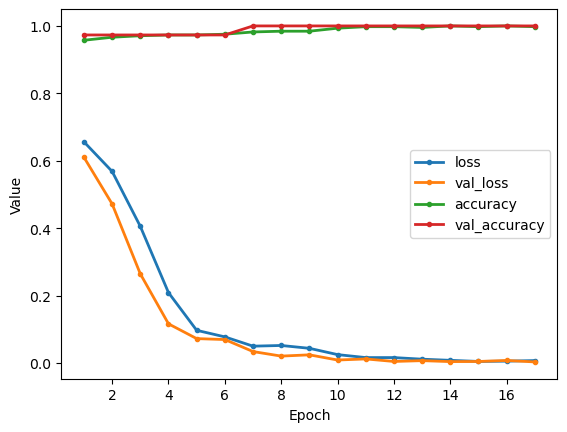

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
549,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,0.013333,0.0,0.0,0.013333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.013333,0.0,0.0,0.013333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (559, 8026)
X_test: (140, 8026)
y_train: (559,)
y_test: (140,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,054,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,098,177 (8.00 MB)

 Trainable params: 2,098,177 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 5s 882ms/step - accuracy: 0.5000 - loss: 0.6934

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5062 - loss: 0.6918 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5223 - loss: 0.6903 - val_accuracy: 0.8661 - val_loss: 0.6712


Epoch 2/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8594 - loss: 0.6713

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8683 - loss: 0.6655

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8774 - loss: 0.6600 - val_accuracy: 0.9018 - val_loss: 0.6115


Epoch 3/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9062 - loss: 0.6120

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9040 - loss: 0.5971

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9086 - loss: 0.5849 - val_accuracy: 0.9196 - val_loss: 0.4993


Epoch 4/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9531 - loss: 0.4949

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9440 - loss: 0.4580

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9412 - loss: 0.4478 - val_accuracy: 0.9464 - val_loss: 0.3707


Epoch 5/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9531 - loss: 0.3208

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9602 - loss: 0.3129

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9634 - loss: 0.3046 - val_accuracy: 0.9464 - val_loss: 0.2493


Epoch 6/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9531 - loss: 0.2514

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9718 - loss: 0.2075

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9770 - loss: 0.1889 - val_accuracy: 0.9643 - val_loss: 0.1251


Epoch 7/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9844 - loss: 0.1006

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9929 - loss: 0.0820

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9938 - loss: 0.0753 - val_accuracy: 0.9732 - val_loss: 0.0704


Epoch 8/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0237

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0233

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0221

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0216 - val_accuracy: 0.9821 - val_loss: 0.0331


Epoch 9/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0135

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9960 - loss: 0.0162

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9966 - loss: 0.0145 - val_accuracy: 0.9821 - val_loss: 0.0287


Epoch 10/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0058

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0043

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9821 - val_loss: 0.0645


Epoch 11/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0015

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9966 - loss: 0.0037 - val_accuracy: 0.9821 - val_loss: 0.0491


Epoch 12/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.1337e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.9710e-04 - val_accuracy: 0.9821 - val_loss: 0.0391


Epoch 13/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.9636e-04

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 6.4699e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 7.0420e-04 - val_accuracy: 0.9821 - val_loss: 0.0391


Epoch 14/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 6.8659e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.8833e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 5.6061e-04 - val_accuracy: 0.9821 - val_loss: 0.0418


Epoch 15/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 3.5301e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.0937e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 7.1731e-04 - val_accuracy: 0.9821 - val_loss: 0.0460


Epoch 16/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 5.0206e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.6997e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 3.7035e-04 - val_accuracy: 0.9821 - val_loss: 0.0494


Epoch 17/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0012

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 6.6614e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 8.7520e-04 - val_accuracy: 0.9821 - val_loss: 0.0377


Epoch 18/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 2.7116e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.5433e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 4.0201e-04 - val_accuracy: 0.9911 - val_loss: 0.0213


Epoch 19/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 3.9669e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.6543e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 3.8533e-04 - val_accuracy: 0.9911 - val_loss: 0.0229


Epoch 20/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 2.5441e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.1368e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 4.6244e-04 - val_accuracy: 0.9821 - val_loss: 0.0344


Epoch 21/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 8.5769e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.5456e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 3.7422e-04 - val_accuracy: 0.9821 - val_loss: 0.0493


Epoch 22/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 2.4309e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.9152e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 1.8570e-04 - val_accuracy: 0.9821 - val_loss: 0.0572


Epoch 23/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 2.4605e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.8788e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 2.1080e-04 - val_accuracy: 0.9821 - val_loss: 0.0616


Epoch 24/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0028

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0014

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9821 - val_loss: 0.0566


Epoch 25/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 1.4907e-04

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.4402e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 1.5067e-04 - val_accuracy: 0.9821 - val_loss: 0.0537


Epoch 26/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 2.4930e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.6741e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 1.6531e-04 - val_accuracy: 0.9821 - val_loss: 0.0521


Epoch 27/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 2.9149e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.6547e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 1.4043e-04 - val_accuracy: 0.9821 - val_loss: 0.0491


Epoch 28/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 1.1378e-04

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.0017e-04

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 1.0577e-04 - val_accuracy: 0.9821 - val_loss: 0.0474



[Train Accuracy: 100.00% - Test Accuracy: 95.71%]


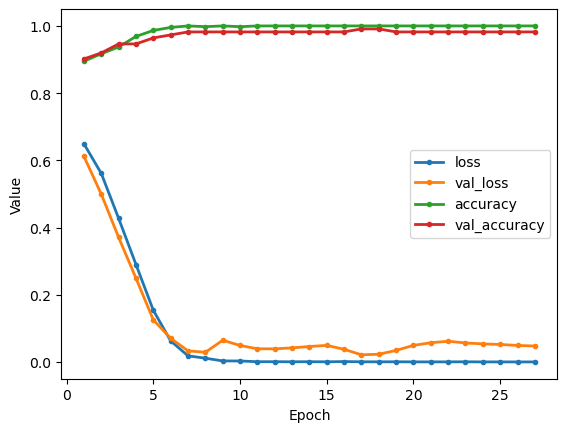

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYTG,YYTT,YYVP,YYWA,YYYH,YYYQ,YYYR,YYYT,YYYX,YYYY
549,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,0.0,0.0,0.0,0.013514,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.013514,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      18,299,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,340,353 (69.96 MB)

 Trainable params: 18,340,353 (69.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 819ms/step - accuracy: 0.5625 - loss: 0.6931

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5430 - loss: 0.6930 

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5269 - loss: 0.6930

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5202 - loss: 0.6928

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5268 - loss: 0.6925

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5384 - loss: 0.6923

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5522 - loss: 0.6920

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5626 - loss: 0.6917 - val_accuracy: 0.9107 - val_loss: 0.6814


Epoch 2/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8594 - loss: 0.6823

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8672 - loss: 0.6814

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8750 - loss: 0.6802

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8828 - loss: 0.6792

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8906 - loss: 0.6784

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8971 - loss: 0.6774

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9032 - loss: 0.6763

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9078 - loss: 0.6755 - val_accuracy: 0.9911 - val_loss: 0.6463


Epoch 3/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.6440

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.6429

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.6416

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9990 - loss: 0.6408

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9986 - loss: 0.6391

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9984 - loss: 0.6369

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9983 - loss: 0.6343

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9982 - loss: 0.6324 - val_accuracy: 1.0000 - val_loss: 0.5721


Epoch 4/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9844 - loss: 0.5678

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9883 - loss: 0.5617 

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9905 - loss: 0.5580

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9919 - loss: 0.5546

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9929 - loss: 0.5515

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9936 - loss: 0.5480

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9942 - loss: 0.5436

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9947 - loss: 0.5402 - val_accuracy: 1.0000 - val_loss: 0.4417


Epoch 5/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.4379

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9961 - loss: 0.4371

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9957 - loss: 0.4300

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9958 - loss: 0.4230

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9960 - loss: 0.4167

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9962 - loss: 0.4096

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9964 - loss: 0.4028

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9966 - loss: 0.3977 - val_accuracy: 1.0000 - val_loss: 0.2829


Epoch 6/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.2760

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.2689

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9983 - loss: 0.2646

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9977 - loss: 0.2587

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9976 - loss: 0.2528

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9975 - loss: 0.2468

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9976 - loss: 0.2411

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9976 - loss: 0.2369 - val_accuracy: 1.0000 - val_loss: 0.1459


Epoch 7/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.1441

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.1375

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.1306

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.1241

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9994 - loss: 0.1197

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9990 - loss: 0.1161

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9989 - loss: 0.1128

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9987 - loss: 0.1103 - val_accuracy: 0.9911 - val_loss: 0.0661


Epoch 8/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0488

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0465

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0459

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0455

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0449

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0443

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0433

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 0.0425 - val_accuracy: 1.0000 - val_loss: 0.0373


Epoch 9/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0169

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0171 

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0167

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0164

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0160

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0155

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0150

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 0.9911 - val_loss: 0.0217


Epoch 10/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0086

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0078 

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0072

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0069 

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0067

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0065

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.9911 - val_loss: 0.0175


Epoch 11/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0069

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0060

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0054

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0050

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0047

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0045

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0043

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9911 - val_loss: 0.0143


Epoch 12/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0014

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0014

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0018

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0019

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0020

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0020

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0020

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9911 - val_loss: 0.0126


Epoch 13/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0024

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0021 

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0020

4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0019

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0018

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0018

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0018

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9911 - val_loss: 0.0117



[Train Accuracy: 100.00% - Test Accuracy: 97.14%]


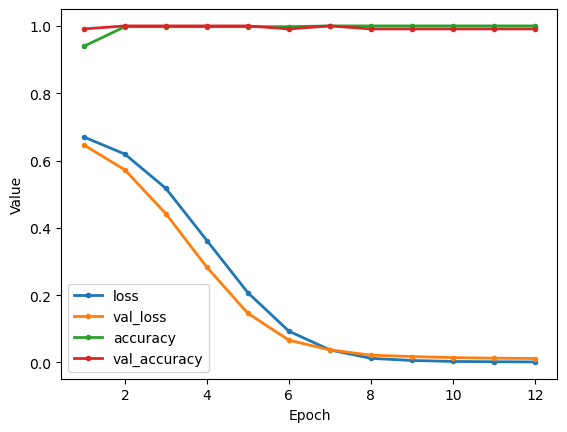

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [26]:
report.save()

Report saved as Output/Reports/S1Fa-like/report_Y3XSE8M2.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################